# Prometne nesreče v Sloveniji #

## Uvod
Za seminarsko nalogo bom analiziral podatke o prometnih nesrečah v Sloveniji za leti 2019 in 2020. Podatke sem pridobil
iz spletne strani policija.si (https://www.policija.si/o-slovenski-policiji/statistika/prometna-varnost). Isti podatki so tudi dostopni
na spletni strani podatki.gov.si (https://podatki.gov.si/dataset/mnzpprometne-nesrece-od-leta-2009-dalje), vendar manjkajo podatki za leto 2020.


## Cilji
  * Analiza in vizualizacija podatkov.
  * Odgovoriti na vnaprej postavljena vprašanja in na morebitna vprašanja, ki se pojavijo ob reševanju problema.
  * Napovedovanje vrednosti alkohola v krvi na podlagi okoliščin nesreče.
  
  
  ### Vprašanja
  * Kateri vozniki povzročajo največ nesreč?
  * Kakšne okoliščine povzročajo največ nesreč?
  * Ali količina alkohola v krvi voznika, vpliva na težavnost poškodbe?
  

## Branje podatkov ##

In [2]:
#knjužnice

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta, date
import scipy.cluster.hierarchy as sch
import scipy
from scipy.stats import multivariate_normal as mvn 
import random
from sklearn.cluster import KMeans
from matplotlib.pyplot import figure

In [4]:
data20 = pd.read_csv("Data/pn2020.csv", ";", encoding="cp1252", decimal=",")
data19 = pd.read_csv("Data/pn2019.csv", ";", encoding="cp1252", decimal=",")

## Priprava podatkov ##

Vse vrsice z mankajočimi vrednostmi odstranimo iz podatkov.

In [6]:
data20 = data20.dropna()
data19 = data19.dropna()

Združimo polji vrednost alkotesta in vrednost strokovnega pregleda. Enote je potrebno vskladiti

In [8]:
# 4 nivoji
alc = []
for a, b in zip(data20["VrednostAlkotesta"], data20["VrednostStrokovnegaPregleda"]):
    if a > 0.8 or b > 0.38:
        alc.append(3)
        continue
    elif ((a <= 0.8 and a > 0.5) or (b <= 0.38 and  b > 0.24)):
        alc.append(2)
        continue
    elif ((a <= 0.5 and a > 0.3) or (b <= 0.24 and  b > 0.14)):
        alc.append(1)
        continue
    else:
        alc.append(0)
data20["stopnjaAlkohola"] = alc

alc = []
for a, b in zip(data19["VrednostAlkotesta"], data19["VrednostStrokovnegaPregleda"]):
    if a > 0.8 or b > 0.38:
        alc.append(3)
        continue
    elif ((a <= 0.8 and a > 0.5) or (b <= 0.38 and  b > 0.24)):
        alc.append(2)
        continue
    elif ((a <= 0.5 and a > 0.3) or (b <= 0.24 and  b > 0.14)):
        alc.append(1)
        continue
    else:
        alc.append(0)
data19["stopnjaAlkohola"] = alc

Spremenimo tip datuma v datetime.

In [10]:
dateFormat19 = np.array([datetime.strptime(datum,"%d.%m.%Y" ) for datum in data19["DatumPN"]])
dateFormat20 = np.array([datetime.strptime(datum,"%d.%m.%Y" ) for datum in data20["DatumPN"]])

In [12]:
data19["datetime"] = dateFormat19
data20["datetime"] = dateFormat20

V nadaljevanju bomo obe mnoožici obdelovali kot eno.

In [14]:
data = pd.concat([data19,data20])

In [16]:
start_date = datetime(2019, 1, 1)
end_date = datetime(2019, 12, 31)
delta = timedelta(days=1)
velikosti = []

while start_date <= end_date:
    velikosti.append(len(dateFormat19[dateFormat19 == start_date]))
    start_date += delta

In [18]:
start_date = datetime(2020, 1, 1)
end_date = datetime(2020, 12, 31)
delta = timedelta(days=1)
velikosti2 = []

while start_date <= end_date:
    velikosti2.append(len(dateFormat20[dateFormat20 == start_date]))
    start_date += delta

Sprememba tima ure

In [20]:
data["UraPN"] = [float(x) for x in data["UraPN"]]

## Analiza ##

### Primerjava let ###

(array([1958., 1648., 1811.,  686.,  845., 1509., 1761., 1883., 1778.,
        1921., 1981., 1903., 1163., 1017., 1076.]),
 array([18262.        , 18286.33333333, 18310.66666667, 18335.        ,
        18359.33333333, 18383.66666667, 18408.        , 18432.33333333,
        18456.66666667, 18481.        , 18505.33333333, 18529.66666667,
        18554.        , 18578.33333333, 18602.66666667, 18627.        ]),
 <BarContainer object of 15 artists>)

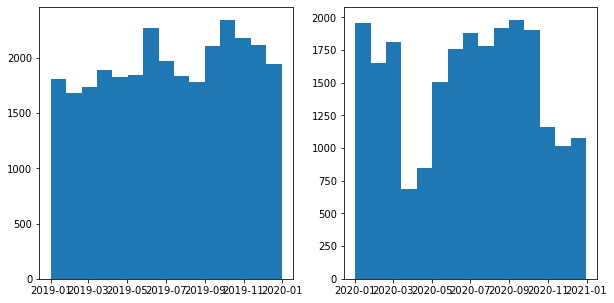

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(dateFormat19, bins=15)
axes[1].hist(dateFormat20, bins=15)

(array([18., 40., 59., 55., 60., 58., 48., 22.,  3.,  3.]),
 array([  6. ,  19.6,  33.2,  46.8,  60.4,  74. ,  87.6, 101.2, 114.8,
        128.4, 142. ]),
 <BarContainer object of 10 artists>)

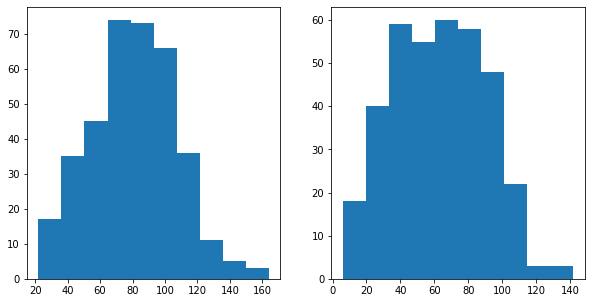

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(velikosti)
axes[1].hist(velikosti2)

### Nad 95% ###

In [26]:
sVelikosti = velikosti + velikosti2

In [28]:
n = len(sVelikosti)
mu = np.mean(sVelikosti)
sigma2 = (n-1)/n * np.var(sVelikosti)

In [30]:
xr = np.linspace(0, 190, 1000)
p_value = 0.95
width = xr[1] - xr[0] 
for qx in xr:
    ltx = xr[xr <= qx]
    P_ltx = [mvn.pdf(x, mu, sigma2) * width for x in ltx] 
    p_value2 = np.sum(P_ltx)
    if p_value <= p_value2:
        print("----")
        print(qx)
        print(p_value2)
        print("----")
        break
    

----
119.43943943943943
0.9504625737490521
----


In [32]:
start_date = datetime(2019, 1, 1)
end_date = datetime(2020, 12, 31)
delta = timedelta(days=1)
datumi = []

while start_date <= end_date:
    datumi.append(start_date)
    start_date += delta

In [34]:
sVelikosti = np.array(sVelikosti)
datumi = np.array(datumi)

In [35]:
datumiNad5 = datumi[sVelikosti >= 119]
vrsticeNad5 = data[data["datetime"] == datumiNad5[0]]
for datum in datumiNad5[1:]:
    trenutni = data[data["datetime"] == datum]
    vrsticeNad5 = pd.concat([vrsticeNad5, trenutni])

In [21]:
#vrsticeNad5

### Vozniki ###

(array([  411.,  2757.,  9510., 10522., 10061.,  9171.,  5575.,  3115.,
         1114.,    59.]),
 array([ -1. ,   9.2,  19.4,  29.6,  39.8,  50. ,  60.2,  70.4,  80.6,
         90.8, 101. ]),
 <BarContainer object of 10 artists>)

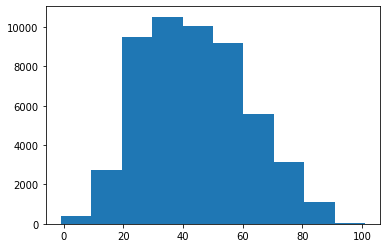

In [22]:
plt.hist(data["Starost"])

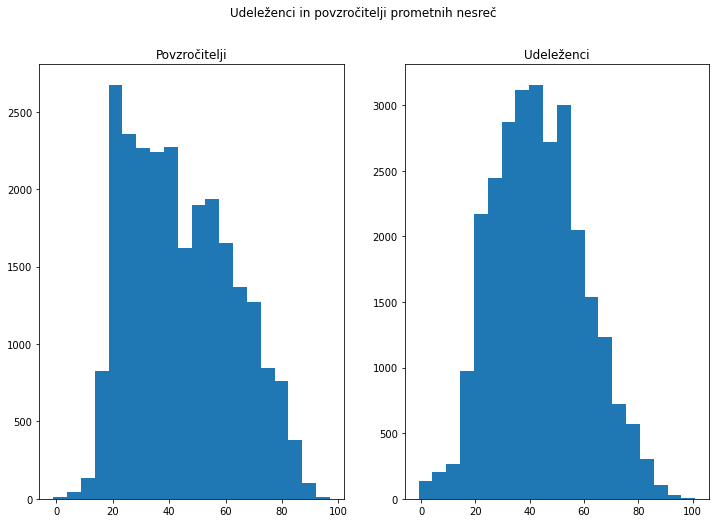

In [23]:
fig, axs = plt.subplots(1,2)
fig.suptitle('Udeleženci in povzročitelji prometnih nesreč')
fig.set_figwidth(12)
fig.set_figheight(8)
axs[0].hist(data[data["Povzrocitelj"] == "POVZROÈITELJ"]["Starost"], bins=20)
axs[0].title.set_text("Povzročitelji")
axs[1].hist(data[data["Povzrocitelj"] == "UDELEŽENEC"]["Starost"], bins=20)
axs[1].title.set_text("Udeleženci")

Graf udeležencev se porazdeljuje dokaj normalno. Graf povzročiteljev pa nekoliko drugače. Največ nesreč povzroča predvsem mladih ljudi (okoli 20 let). Kar nakazuje na njihovo neizkušenost v prometu. Z višjo starostjo pa ta številka pada.

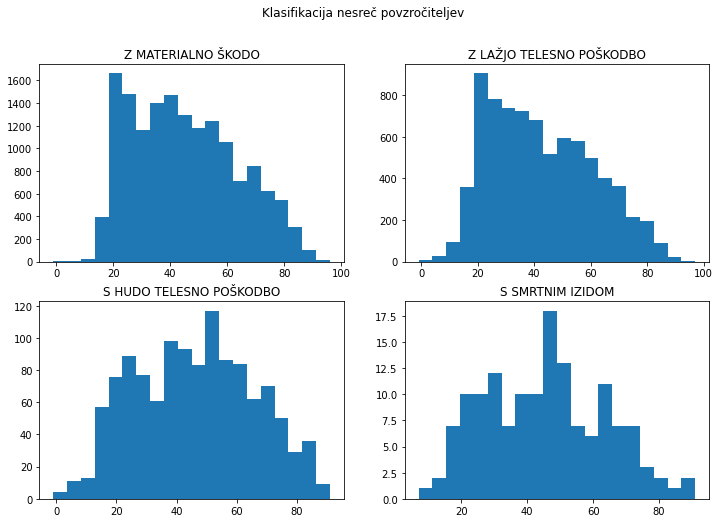

In [24]:
fig, axs = plt.subplots(2,2)
fig.suptitle('Klasifikacija nesreč povzročiteljev')
fig.set_figwidth(12)
fig.set_figheight(8)
axs[0,0].hist(data[(data["Povzrocitelj"] == "POVZROÈITELJ") & (data["KlasifikacijaNesrece"] == "Z MATERIALNO ŠKODO")]["Starost"], bins=20)
axs[0,0].title.set_text("Z MATERIALNO ŠKODO")
axs[0,1].hist(data[(data["Povzrocitelj"] == "POVZROÈITELJ") & (data["KlasifikacijaNesrece"] == "Z LAŽJO TELESNO POŠKODBO")]["Starost"], bins=20)
axs[0, 1].title.set_text("Z LAŽJO TELESNO POŠKODBO")
axs[1,0].hist(data[(data["Povzrocitelj"] == "POVZROÈITELJ") & (data["KlasifikacijaNesrece"] == "S HUDO TELESNO POŠKODBO")]["Starost"], bins=20)
axs[1,0].title.set_text("S HUDO TELESNO POŠKODBO")
axs[1,1].hist(data[(data["Povzrocitelj"] == "POVZROÈITELJ") & (data["KlasifikacijaNesrece"] == "S SMRTNIM IZIDOM")]["Starost"], bins=20)
axs[1,1].title.set_text("S SMRTNIM IZIDOM")

Iz grafov lahko razberemo, da največ nesreč z materialno škodo in z lažjo telesno poškodbo povzročajo predvsem mladi vozniki (okoli 20). Kar se ujema s prejšnim grafom. Medtem pa za nesreče s hudo telesno poškodbo in s smrtnim izidom to nevelja. Največ takih nesreč povzročaj vozniki zrelih let (okoli 50 let). Kar nakazuje na morebitno precenjevanje lastnih sposobnosti.

(array([8660., 3327., 3215., 3171., 1980., 1904., 1556.,  698.,  154.,
           9.]),
 array([ 0. ,  7.3, 14.6, 21.9, 29.2, 36.5, 43.8, 51.1, 58.4, 65.7, 73. ]),
 <BarContainer object of 10 artists>)

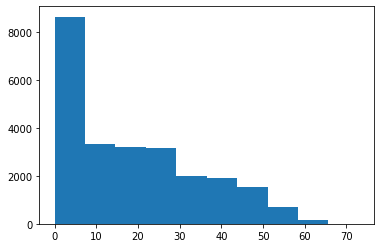

In [25]:
plt.hist(data[data["Povzrocitelj"] == "POVZROÈITELJ"]["VozniskiStazVLetih"])

Graf prikazuje porazdelitev vozniškega staža v lethi in potrjuje prejsnje ugotovitve, da največ nesreč povzročajo neizkušeni vozniki.

(array([  76.,    0.,    0., 2877.,    0.,    0., 1815.,    0.,    0.,
         483.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

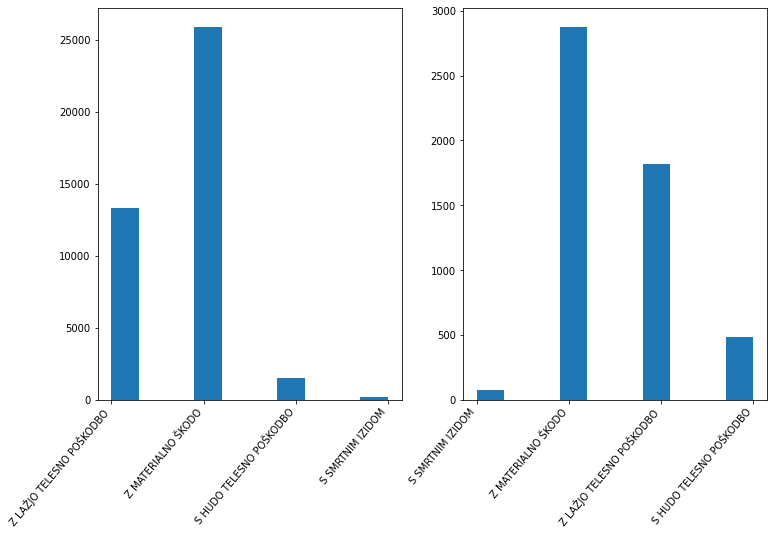

In [26]:
fig, axs = plt.subplots(1,2)
fig.set_figwidth(12)
fig.set_figheight(8)
fig.autofmt_xdate(rotation=50)
axs[0].hist(data[data["UporabaVarnostnegaPasu"] == "DA"]["KlasifikacijaNesrece"])

axs[1].hist(data[data["UporabaVarnostnegaPasu"] == "NE" ]["KlasifikacijaNesrece"])

In [27]:
(len(data[(data["UporabaVarnostnegaPasu"] == "DA") & (data["KlasifikacijaNesrece"] == "S SMRTNIM IZIDOM")]) + len(data[(data["UporabaVarnostnegaPasu"] == "DA") & (data["KlasifikacijaNesrece"] == "S HUDO TELESNO POŠKODBO")]))/ len(data[data["UporabaVarnostnegaPasu"] == "DA"])

0.042141007475448286

In [28]:
(len(data[(data["UporabaVarnostnegaPasu"] == "NE") & (data["KlasifikacijaNesrece"] == "S SMRTNIM IZIDOM")]) + len(data[(data["UporabaVarnostnegaPasu"] == "NE") & (data["KlasifikacijaNesrece"] == "S HUDO TELESNO POŠKODBO")])) / len(data[data["UporabaVarnostnegaPasu"] == "NE"])

0.10645591315939822

Ali uporaba varnostnega pasu vpliva na klasifikacijo nesreče? Da, uporaba varnostnega pasu kar razpolovi verjetnost ,da je pri nesreči smrtni izid ali izid s hudo telesno poškodbo.

### Okoliščine nesreče

In [29]:
import scipy.cluster.hierarchy as sch

Priprava za hierarhično gručenje

In [30]:
grucenje = data[['KlasifikacijaNesrece', 'UraPN', 'VNaselju', 'Lokacija','VzrokNesrece',
       'TipNesrece', 'VremenskeOkoliscine', 'StanjePrometa', 'StanjeVozisca',
       'VrstaVozisca', 'Povzrocitelj', 'Starost', 'Spol','PoskodbaUdelezenca',
       'VrstaUdelezenca', 'UporabaVarnostnegaPasu', 'VozniskiStazVLetih',
       'VozniskiStazVMesecih','stopnjaAlkohola']]

## Priprava podatkov za hierarhično gručenje

In [34]:
def spremeni(b):
    seznam = dict()
    seznam2 = []
    i = 0
    for x in b:
        if x in seznam.keys():
            seznam2.append(seznam[x])
        else:
            seznam[x] = i
            seznam2.append(i)
            i += 1
    return seznam2

In [35]:
sez = ['KlasifikacijaNesrece', 'VNaselju', 'Lokacija','VzrokNesrece',
       'TipNesrece', 'VremenskeOkoliscine', 'StanjePrometa', 'StanjeVozisca',
       'VrstaVozisca', 'Povzrocitelj', 'Spol','PoskodbaUdelezenca',
       'VrstaUdelezenca', 'UporabaVarnostnegaPasu']
for a in sez:
    grucenje[a] = spremeni(grucenje[a])

<ipython-input-35-3d90790c4385>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grucenje[a] = spremeni(grucenje[a])


In [58]:
L = sch.linkage(grucenje.sample(1000), method="average", metric="jaccard")

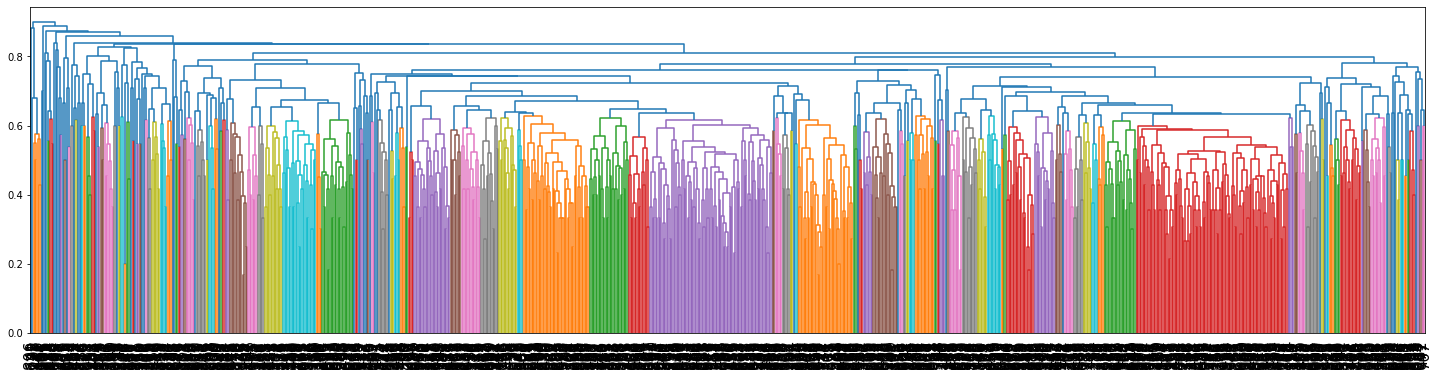

In [59]:
plt.figure(figsize=(25, 6))
D      = sch.dendrogram(L, leaf_font_size=15)
plt.show()

In [62]:
model = KMeans()

In [36]:
class KMeans:
    
    def __init__(self, k=10, max_iter=100):
        """
        Initialize KMeans clustering model.
        
        :param k
            Number of clusters.
        :param max_iter
            Maximum number of iterations.
        """
        self.k         = k
        self.max_iter  = max_iter    
    
    def fit(self, X):
        """
        Fit the Kmeans model to data.
        
        :param X
            Numpy array of shape (n, p)
            n: number of data examples
            p: number of features (attributes)
        
        :return 
            labels: array of shape (n, ), cluster labels (0..k-1)
            centers: array of shape (k, p, )
        """
        
        n, p    = X.shape
        labels  = np.random.choice(range(self.k), size=n, replace=True)
        
        # Choose k random data points for initial centers
        centers = np.array([X[i] for i in np.random.choice(range(X.shape[0]), 
                                                   size=self.k)]) 
        i = 0
        while i < self.max_iter:
            
            # Find nearest cluster
            for j, x in enumerate(X):
                ki = np.argmin(np.sum((centers - x) ** 2, axis=1))
                labels[j] = ki
                
            # Store previous centers
            previous_centers = centers.copy()
                
            # Move centroid
            for ki in range(self.k):
                centers[ki] = X[labels == ki].mean(axis=0)    
            i += 1    
        
        return labels, centers

In [37]:
te = grucenje.sample(1000)

In [38]:
sez = ['UraPN', 'VNaselju', 'Lokacija','VzrokNesrece',
       'TipNesrece', 'VremenskeOkoliscine', 'StanjePrometa', 'StanjeVozisca',
       'VrstaVozisca', 'Povzrocitelj', 'Starost', 'Spol','PoskodbaUdelezenca',
       'VrstaUdelezenca', 'UporabaVarnostnegaPasu', 'VozniskiStazVLetih',
       'VozniskiStazVMesecih','stopnjaAlkohola']
x = np.array(te[sez])
true_clusters = grucenje["KlasifikacijaNesrece"]
model = KMeans(k=4, max_iter=10)
labels, centers = model.fit(x)

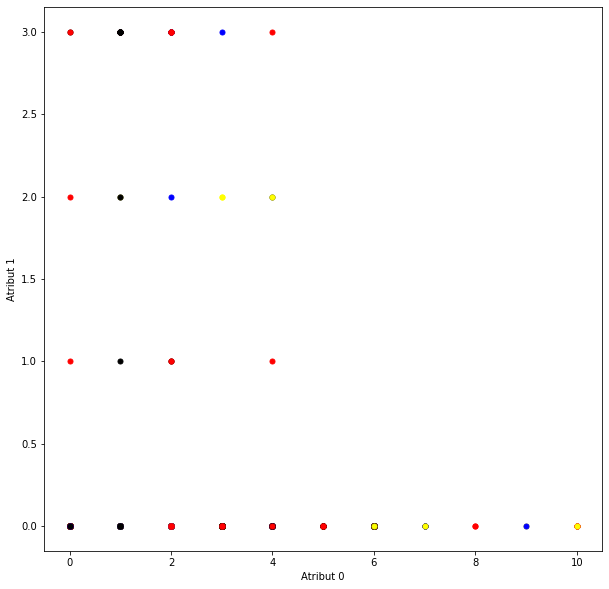

In [39]:
plt.figure(figsize=(10, 10))
color = {0:"red", 1:"blue", 2:"yellow", 3:"black"}
for c, x in zip(labels, x):
    plt.plot(x[3], x[17], ".", color=color[c], markersize=10.0)
plt.xlabel("Atribut 0")
plt.ylabel("Atribut 1")
plt.show()

In [40]:
from sklearn.metrics import adjusted_mutual_info_score
score = adjusted_mutual_info_score(classes, predictions)

NameError: name 'classes' is not defined

In [91]:
x

array([[ 7.25,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [11.15,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [12.58,  0.  ,  0.  , ..., 36.  ,  4.  ,  0.  ],
       ...,
       [10.3 ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [19.3 ,  0.  ,  0.  , ..., 43.  ,  2.  ,  0.  ],
       [ 7.5 ,  1.  ,  1.  , ..., 21.  ,  0.  ,  0.  ]])

# Mogoce izpusti

(array([5035.,    0.,    0., 8601.,    0.,    0.,  201.,    0.,    0.,
         774.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

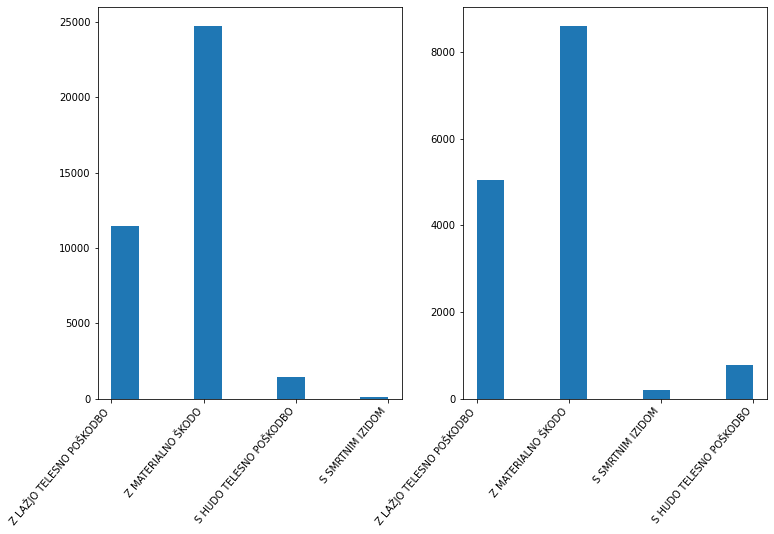

In [32]:
fig, axs = plt.subplots(1,2)
fig.set_figwidth(12)
fig.set_figheight(8)
fig.autofmt_xdate(rotation=50)
axs[0].hist(data[data["VNaselju"] == "DA"]["KlasifikacijaNesrece"])
axs[1].hist(data[data["VNaselju"] == "NE"]["KlasifikacijaNesrece"])

In [33]:
data.columns

Index(['ZaporednaStevilkaPN', 'KlasifikacijaNesrece', 'UpravnaEnotaStoritve',
       'DatumPN', 'UraPN', 'VNaselju', 'Lokacija', 'VrstaCesteNaselja',
       'SifraCesteNaselja', 'TekstCesteNaselja', 'SifraOdsekaUlice',
       'TekstOdsekaUlice', 'StacionazaDogodka', 'OpisKraja', 'VzrokNesrece',
       'TipNesrece', 'VremenskeOkoliscine', 'StanjePrometa', 'StanjeVozisca',
       'VrstaVozisca', 'GeoKoordinataX', 'GeoKoordinataY',
       'ZaporednaStevilkaOsebeVPN', 'Povzrocitelj', 'Starost', 'Spol',
       'UEStalnegaPrebivalisca', 'Drzavljanstvo', 'PoskodbaUdelezenca',
       'VrstaUdelezenca', 'UporabaVarnostnegaPasu', 'VozniskiStazVLetih',
       'VozniskiStazVMesecih', 'VrednostAlkotesta',
       'VrednostStrokovnegaPregleda', 'stopnjaAlkohola', 'datetime'],
      dtype='object')

(array([ 643.,  365.,  268.,  325., 1018., 2322., 3215., 3331., 4132.,
        3408., 3369., 5172., 5472., 5177., 3649., 2894., 2837., 2216.,
        1559.,  923.]),
 array([ 0.    ,  1.1795,  2.359 ,  3.5385,  4.718 ,  5.8975,  7.077 ,
         8.2565,  9.436 , 10.6155, 11.795 , 12.9745, 14.154 , 15.3335,
        16.513 , 17.6925, 18.872 , 20.0515, 21.231 , 22.4105, 23.59  ]),
 <BarContainer object of 20 artists>)

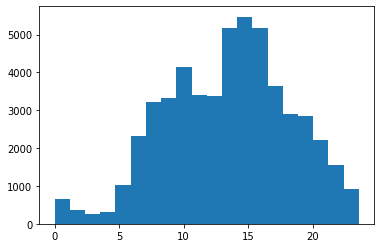

In [54]:
plt.hist(data["UraPN"], bins=20)

Največ nesreč se zgodi okoli 15 ure. Ljudje ob taki uri ponavadi zaključijo delo. Poleg tega je še en vrh okoli 10 ure kar nanaša na to, da se ljudje odpravijo na malico.

(array([10946.,   848.,  1512.,   236.,   505.,   441.,  1532.,  1020.,
         1423.,  1163.,   390.,   531.,   885.,   488.,   397.,   771.,
         2463.,  1227.,   319.,   296.,   738.,   277.,  5543.,   383.,
          458.,   230.,   306.,   718.,   980.,   507.,   299.,  2231.,
          407.,   573.,   449.,   112.,   191.,   519.,  2121.,   308.,
          882.,   544.,   385.,   453.,   363.,   199.,   338.,   351.,
          920.,   796.,   268.,   475.,   374.,   296.,   218.,   160.,
          530.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
        52., 53., 54., 55., 56., 57.]),
 <BarContainer object of 57 artists>)

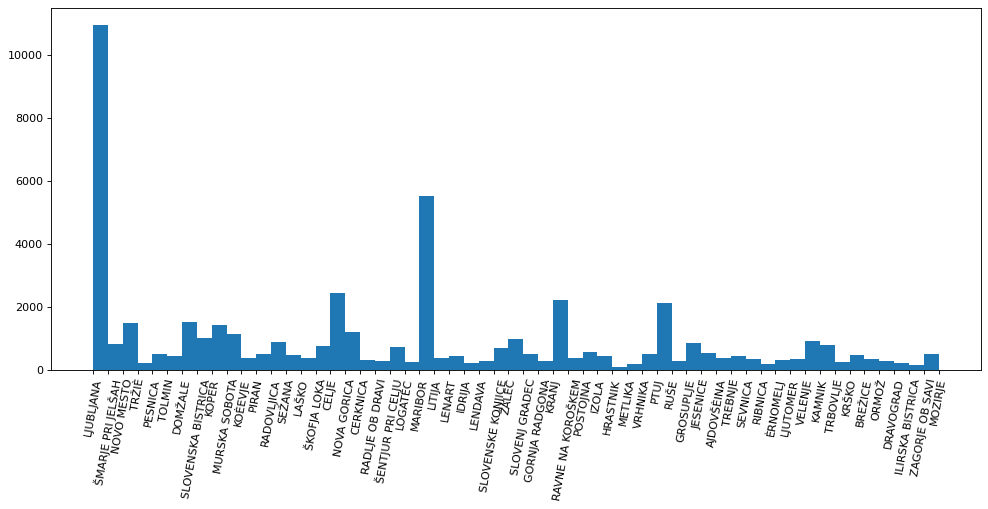

In [57]:
figure(figsize=(15, 6), dpi=80)
plt.xticks(rotation=80)
plt.hist(data["UpravnaEnotaStoritve"], bins=57)

Načeloma velja več nesreč imajo regije, večje je število prebivalcev.

In [82]:
data["GeoKoordinataY"].describe()

count     50707.000000
mean     492275.766462
std       52038.764337
min      379952.000000
25%      459032.000000
50%      487571.000000
75%      539498.000000
max      616987.000000
Name: GeoKoordinataY, dtype: float64

In [84]:
data["GeoKoordinataX"].describe()

count     50707.000000
mean     114587.461278
std       31650.012761
min       33476.000000
25%       98206.500000
50%      114280.000000
75%      139388.000000
max      190121.000000
Name: GeoKoordinataX, dtype: float64

## Koordinate

Odstranimo vrednosti s koordinatami, ki imajo x = 0 ali y = 0.

In [36]:
data = data[data["GeoKoordinataX"] != 0]
data = data[data["GeoKoordinataY"] != 0]

In [48]:
# (max, min, št. vrednosti)
x = np.linspace(33476,  190121, 100)
y = np.linspace(379952,   616987, 100)
polje = np.zeros((100,100))

X = data["GeoKoordinataX"]
Y = data["GeoKoordinataY"]


In [49]:
for a in range(len(data["GeoKoordinataX"])):
    for b1 in range(100):
        if x[b1] - 783.225 <= data["GeoKoordinataX"].values[a] < x[b1] + 783.225:
            for b2 in range(100):
                if y[b2] - 1185.175 <= data["GeoKoordinataY"].values[a] < y[b2] + 1185.175:
                    polje[b1, b2] += 1

<ipython-input-51-ab07c7ccc3de>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  p = ax.pcolor(x, y, polje)


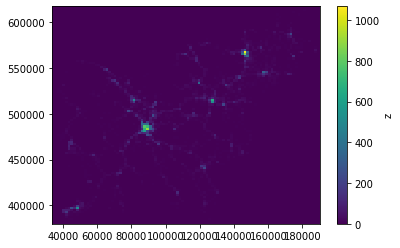

In [51]:
fig, ax = plt.subplots()

p = ax.pcolor(x, y, polje)
cb = fig.colorbar(p, ax=ax, label="z")

### Vpliv alkohola

(array([49629.,     0.,     0.,     0.,     0.,     0.,   489.,     0.,
            0.,     0.,     0.,     0.,     0.,   833.,     0.,     0.,
            0.,     0.,     0.,  1344.]),
 array([0.  , 0.15, 0.3 , 0.45, 0.6 , 0.75, 0.9 , 1.05, 1.2 , 1.35, 1.5 ,
        1.65, 1.8 , 1.95, 2.1 , 2.25, 2.4 , 2.55, 2.7 , 2.85, 3.  ]),
 <BarContainer object of 20 artists>)

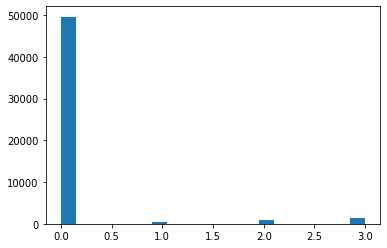

In [35]:
plt.hist(data["stopnjaAlkohola"], bins=20)

In [36]:
data["KlasifikacijaNesrece"]

0        Z LAŽJO TELESNO POŠKODBO
1        Z LAŽJO TELESNO POŠKODBO
2        Z LAŽJO TELESNO POŠKODBO
3        Z LAŽJO TELESNO POŠKODBO
4              Z MATERIALNO ŠKODO
                   ...           
26068          Z MATERIALNO ŠKODO
26069          Z MATERIALNO ŠKODO
26070     S HUDO TELESNO POŠKODBO
26071          Z MATERIALNO ŠKODO
26072          Z MATERIALNO ŠKODO
Name: KlasifikacijaNesrece, Length: 52295, dtype: object

(array([15655.,     0.,     0., 31775.,     0.,     0.,  1954.,     0.,
            0.,   245.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

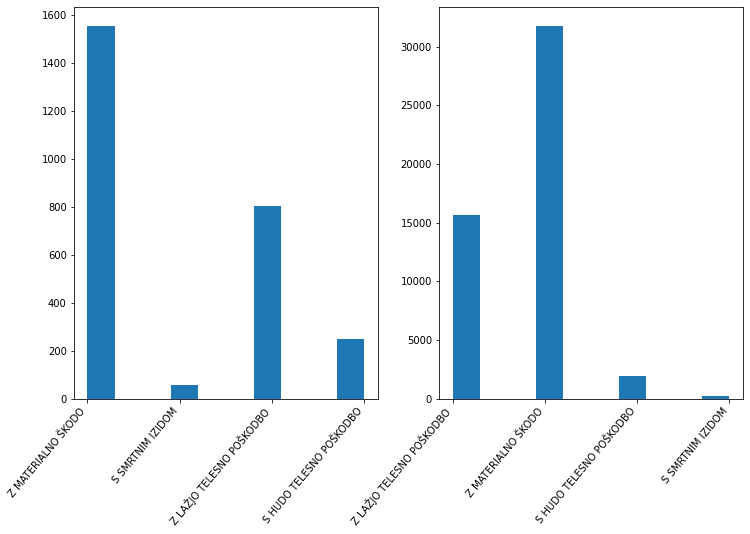

In [37]:
fig, axs = plt.subplots(1,2)
fig.set_figwidth(12)
fig.set_figheight(8)
fig.autofmt_xdate(rotation=50)
axs[0].hist(data[data["stopnjaAlkohola"] > 0]["KlasifikacijaNesrece"])
axs[1].hist(data[data["stopnjaAlkohola"] == 0]["KlasifikacijaNesrece"])

Pod vplivom alkohola

In [38]:
(len(data[(data["stopnjaAlkohola"] > 0) & (data["KlasifikacijaNesrece"] == "S SMRTNIM IZIDOM")]) + len(data[(data["stopnjaAlkohola"] > 0) & (data["KlasifikacijaNesrece"] == "S HUDO TELESNO POŠKODBO")])) / len(data[data["stopnjaAlkohola"] > 0])

0.11515378844711177

Niso pod vplivom alkohola

In [39]:
(len(data[(data["stopnjaAlkohola"] > 0) & (data["KlasifikacijaNesrece"] == "S SMRTNIM IZIDOM")]) + len(data[(data["stopnjaAlkohola"] < 0) & (data["KlasifikacijaNesrece"] == "S HUDO TELESNO POŠKODBO")])) / len(data[data["stopnjaAlkohola"] > 0])

0.021005251312828207

Povprečje nesreč s smrtnim izidom in s hudo telesno poškodbo je pri voznikih, ki so bili pod vplivom alkohola večje kot od tistih, ki niso bili.

## Napovedovanje

In [40]:
#plt.hist(data20["DatumPN"])

In [41]:
#datetime.strptime(data19["DatumPN"][0], "%d.%m.%Y")

In [42]:
#plt.plot(data19["DatumPN"])